## Solving The Krusell-Smith model using sequence-space Jacobian

In this note, I illustrate how to solve the Krussell-Smith model using the sequence-space Jacobian.
This is largely based on the codes and notebooks from Auclert, Bardóczy, Rognlie, Straub (2021) 
Modified by Tomás Martinez.

The Krussell-Smith model is defined below. The HH part is the standard consumption-savings part:

\begin{align*}
V_t(a, e) = \max_{c, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} + \beta \mathbb{E}_t\left[V_{t+1}(a',e')|e \right] \right\}
\\
c + a' &= (1 + r_t)a + w_t e 
\\
a &\geq 0
\end{align*}

The aggregate production function is a Cobb-Douglas: $Y_t = Z_t K_t^\alpha L_t$. 

In [97]:
import copy
import numpy as np
import matplotlib.pyplot as plt

from sequence_jacobian import het, simple, create_model, hetblocks          # functions
from sequence_jacobian import interpolate, grids, misc, JacobianDict   # modules

# Plot parameters
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 12})

path = '/Users/tomasrm/Library/CloudStorage/Dropbox/Teaching/Other/BCB HA Course/Codes' # this is only used to save plots


To use the package, we must define each block of the model. Every block represent a function sequence space. 
Before we solve the model, let's try to understand what the code does and how can we access each part of it. 
Let's start with the "@simple" blocks. These blocks are "static" in the sense that only their conteporaneous inputs affect their outputs. In the KS model, these are the firm and equilibrium block. 

First, we will define both blocks. It must include all inputs of the block, including endogenous variables and parameters.
Note the notation "Dynare style": the predetermined variable has  (-1).

Remember that in python you can always call the "help function" to understand each element of the codes. Every block has "methods" that you can call.
Let's use the help function to find the methods of the blocks, and then try to understand what they do.


In [71]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y


@simple
def mkt_clearing(K, A, Y, C, delta):
    asset_mkt = A - K
    I = K - (1 - delta) * K(-1)
    goods_mkt = Y - C - I
    return asset_mkt, goods_mkt, I

# Let's inspect the block: 
help(firm) # We can use help, but to undertand all methodds the best way to do it is to check "simple_block.py" or iterate as below

# Check the methods, there are many of them! 
method_list = [method for method in dir(firm) if method.startswith('__') is False]
print(method_list)



Help on SimpleBlock in module sequence_jacobian.blocks.simple_block object:

class SimpleBlock(sequence_jacobian.blocks.block.Block)
 |  SimpleBlock(f)
 |  
 |  Generated from simple block written in Dynare-ish style and decorated with @simple, e.g.
 |  
 |  @simple
 |  def production(Z, K, L, alpha):
 |      Y = Z * K(-1) ** alpha * L ** (1 - alpha)
 |      return Y
 |  
 |  which is a SimpleBlock that takes in Z, K, L, and alpha, all of which can be either constants
 |  or series, and implements a Cobb-Douglas production function, noting that for production today
 |  we use the capital K(-1) determined yesterday.
 |  
 |  Key methods are .ss, .td, and .jac, like HetBlock.
 |  
 |  Method resolution order:
 |      SimpleBlock
 |      sequence_jacobian.blocks.block.Block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, f)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  compu

In [24]:
# let's inspect the method SS:
help(firm.steady_state)
help(firm.jacobian)

Help on method steady_state in module sequence_jacobian.blocks.block:

steady_state(calibration: Union[sequence_jacobian.classes.steady_state_dict.SteadyStateDict, Dict[str, Union[numbers.Real, Any]]], dissolve: List[str] = [], options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.steady_state_dict.SteadyStateDict method of sequence_jacobian.blocks.simple_block.SimpleBlock instance
    Evaluate a partial equilibrium steady state of Block given a `calibration`.

Help on method jacobian in module sequence_jacobian.blocks.block:

jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, inputs: List[str], outputs: Optional[List[str]] = None, T: Optional[int] = None, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.simple_block.SimpleBlock instance
    Calculate a partial equilibrium Jacobian to a set of

In [28]:
# Let's try the method steady state
simple_par = {'delta': 0.025, 'alpha': 0.33, 'L': 1.0, 'Z': 1.0, 'K':12.0}
ss_firm = firm.steady_state(simple_par)
print(f'Dictionary: {ss_firm}') # This a dictionary that we can call, let's print the inputs!
print(f"Inputs: {firm.inputs}")
print(f"Outputs: {firm.outputs}")
# print the evaluation of SS:
print("Z:", ss_firm['Z'])
print("Y:", ss_firm['Y'])





Dictionary: <SteadyStateDict: ['K', 'L', 'Z', 'alpha', 'delta', 'r', 'w', 'Y']>
Inputs: ['K', 'L', 'Z', 'alpha', 'delta']
Outputs: ['r', 'w', 'Y']
Z: 1.0
Y: 2.2705434189009517


We are now going to explore more complexes blocks. The heterogeneous "@het" solves the recursive problem and aggregate the distribution.

There are two ways to introduce HA blocks to SSJ. The first is using one of their pre-build blocks. The second is building yourself. 
This is what they say about it (in the hank notebook):

"
The SSJ toolkit comes with 3 generic HetBlocks, located in `sequence_jacobian/hetblocks`.
- `hh_sim`: standard incomplete markets model
- `hh_labor`: standard incomplete markets model with frictionless labor supply
- `hh_twoasset`: two-asset model with convex portfolio adjustment cost

By using hetinputs and hetoutputs, these core blocks may be embedded in different macro environments. This is the simplest way of using the SSJ toolkit, which may suffice for many applications.

If you wish to solve a model that's not just a variation on these off-the-shelf HetBlocks, there's two cases to consider. 
1. The model fits into the HetBlock paradigm. E.g., standard incomplete markets models with additional choices such as search intensity. All you need to do is write a new backward iteration function. Use it to instantiate a new HetBlock and get all the HetBlock methods for free. 
2. The model does not fit the HetBlock paradigm. E.g., models in which discrete endogenous states. In this case, we recommend that you "bring your own Jacobian". That is, solve the Jacobian of your block outside the SSJ toolkit. Once you turn them into an instance of `JacobianDict` (like we did in section 4 of the Krusell-Smith notebook), you can include them in models in lieu of an actual block. This is sufficient for using linear solution methods (`impulse_linear`, `jacobian` and their `solved_` versions) at the macro model level.  

"

Let's first use the pre-build block. Then we try to build ourselves. 


In [42]:
hh = hetblocks.hh_sim.hh # This is the standard incomplete markets model
print(hh)
print(f'Inputs: {hh.inputs}')
print(f'Macro outputs: {hh.outputs}')
print(f'Micro outputs: {hh.internals}')

# === We must input the "a_grid", the income state "y", the transition probability function PI. The resto are just numbers (the interest rate, beta, elasticity of subs).

# ==== This function makes the grids
# check the help function if needed: 
#help(grids.markov_tauchen)
#help(grids.agrid)

def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, pi_e, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, pi_e, Pi, a_grid

def earnings(w, e_grid):
    y =  w * e_grid
    return y

household = hh.add_hetinputs([make_grid, earnings])

print(household)
print(f'Inputs (only scalars): {household.inputs}')

<HetBlock 'hh'>
Inputs: ['a_grid', 'y', 'r', 'beta', 'eis', 'Pi']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c']
<HetBlock 'hh' with hetinput 'make_grid_earnings'>
Inputs (only scalars): ['r', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'w']


Once you have all the blocks. Just combine them to form a model:

Check all the inputs necessary after to decide what to calibrate. Moreover, you must define what is unknown and what is target in the SS.

In [45]:
ks_model = create_model([household, firm, mkt_clearing], name="Krusell-Smith")
#help(ks_model)
print(ks_model)
print(f"Inputs: {ks_model.inputs}")
print(f"Outputs: {ks_model.outputs}")


<Model 'Krusell-Smith'>
Inputs: ['beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']
Outputs: ['A', 'C', 'r', 'w', 'Y', 'asset_mkt', 'goods_mkt']


Steady state dictionary: <SteadyStateDict: ['eis', 'delta', 'alpha', 'rho_e', 'sd_e', 'L', 'nE', 'nA', 'amin', 'amax', 'beta', 'Z', 'K', 'r', 'w', 'Y', 'A', 'C', 'asset_mkt', 'goods_mkt'], internals=['hh']>

Parameters and Eq. var:
alpha :  0.33
Z :  1.0
K :  12.211082563478255
Y :  2.2836464880561236
beta :  0.96
r :  0.03671470360150128
w :  1.5300431469976026
asset_mkt :  -2.611244553918368e-13
goods_mkt :  -1.9394247319226565e-08

Internals of the steady state:
dict_keys(['e_grid', 'pi_e', 'Pi', 'a_grid', 'y', 'a', 'c', 'Va', 'Dbeg', 'D'])

Plotting the Consumption policy function:


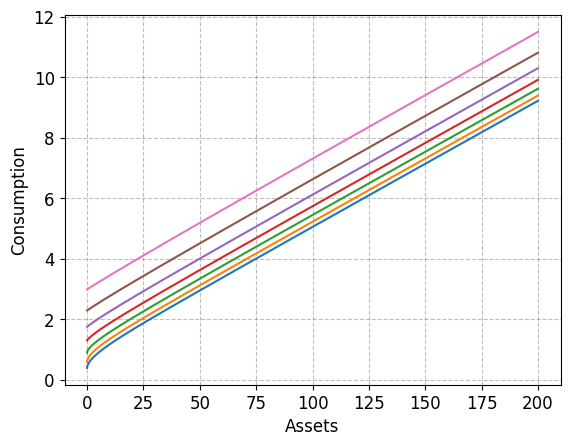

In [141]:
# Think carefully which unknowns and which target you want to use
calibration = {'eis': 1, 'delta': 0.025, 'alpha': 0.33, 'rho_e': 0.966, 'sd_e': 0.5, 'L': 1.0,
               'nE': 7, 'nA': 500, 'amin': 0, 'amax': 200, 'beta': 0.96,  'Z': 1.0}
unknowns_ss = {'K': (8.0, 16.0)}
targets_ss = {'asset_mkt': 0.}


ss = ks_model.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

# print steady state variable:
print(f'Steady state dictionary: {ss}\n')
print(f'Parameters and Eq. var:')
for i in ['alpha','Z', 'K','Y' ,'beta','r', 'w', 'asset_mkt','goods_mkt']:
    print(i, ": ", ss[i])

print('\nInternals of the steady state:')
print(ss.internals['hh'].keys()) # policies, and distributions

# For instace, if I want to access:
#dsn = ss.internals['hh']['D'] # the distribution:
#dsn.shape
#cp = ss.internals['hh']['c'] #  policy consumption:

print('\nPlotting the Consumption policy function:')
plt.plot(ss.internals['hh']['a_grid'], ss.internals['hh']['c'].T)
plt.xlabel('Assets'), plt.ylabel('Consumption')
plt.show()


We have the SS of the model, so we can evaluate the Jacobians. 
The Jacobian of dimension (i, j) is $dY_i/dX_j$, where $i-1$ and $j-1$ is the time of the shock. 
So the first entry is $dY_0/dX_0$, the response of Y0 to a shock in $X_0$.

Let's check the one from the firm.
Since Z only enter in the production function conteporaneously and there are no leads or lags, the jacobian is sparse:



In [79]:
help(firm.jacobian)
J_firm = firm.jacobian(ss, inputs=['K', 'Z'])

print("J_{Y,Z}:\n", J_firm['Y']['Z'].matrix(5)) # jacobian: effect dY/dZ -> derivative of Y wrt to Z.
print('\n')
print(J_firm['Y']['Z'])

J_mkt = mkt_clearing.jacobian(ss, inputs=['K'])
print("J_{I,K}:\n", J_mkt['I']['K'].matrix(5)) # Also sparse, but with a Dyn. Component.

# for the heterogeneous jacobian, you must specify the time
T=5
J_ha = household.jacobian(ss, inputs=['r', 'w'], T=T)
print("\nJ_{C,r}:\n", J_ha['C']['r'])


Help on method jacobian in module sequence_jacobian.blocks.block:

jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, inputs: List[str], outputs: Optional[List[str]] = None, T: Optional[int] = None, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.simple_block.SimpleBlock instance
    Calculate a partial equilibrium Jacobian to a set of `input` shocks at a steady state `ss`.

J_{Y,Z}:
 [[2.28364649 0.         0.         0.         0.        ]
 [0.         2.28364649 0.         0.         0.        ]
 [0.         0.         2.28364649 0.         0.        ]
 [0.         0.         0.         2.28364649 0.        ]
 [0.         0.         0.         0.         2.28364649]]


SimpleSparse({(0, 0): 2.284})
J_{I,K}:
 [[ 1.     0.     0.     0.     0.   ]
 [-0.975  1.     0.     0.     0.   ]
 [ 0.    -0.975  1.   

The package uses the DAG of the model to use the Jacobian to construct the impulse response function.
Recall that the GE response of capital to a TFP shock is:

$dK=-H_K^{-1}H_ZdZ$

and $G_K \equiv -H_K^{-1}H_Z$ characterizes the linearized response of K to Z. 

Once we input the steady state around which to linearize and the truncation horizon, it automatizes everything:

In [117]:
inputs = ['Z']
unknowns = ['K']
targets = ['asset_mkt']
help(ks_model.solve_jacobian)

T = 500
G = ks_model.solve_jacobian(ss, unknowns, targets, inputs, T=T)

print("\nInputs and Outputs of G", G)

# We can recover the model response of any output to the shock Z in the horizon T:
print("\nG[r][Z] is an array of shape TxT:", G['r']['Z'].shape)

print("\n5 first columns and row of G:\n", G['r']['Z'][0:4,0:4])

Help on method solve_jacobian in module sequence_jacobian.blocks.block:

solve_jacobian(ss: sequence_jacobian.classes.steady_state_dict.SteadyStateDict, unknowns: List[str], targets: List[str], inputs: List[str], outputs: Optional[List[str]] = None, T: int = 300, Js: Dict[str, sequence_jacobian.classes.jacobian_dict.JacobianDict] = {}, options: Dict[str, dict] = {}, H_U_factored: Optional[sequence_jacobian.classes.jacobian_dict.FactoredJacobianDict] = None, **kwargs) -> sequence_jacobian.classes.jacobian_dict.JacobianDict method of sequence_jacobian.blocks.combined_block.CombinedBlock instance
    Calculate a general equilibrium Jacobian to a set of `exogenous` shocks
    at a steady state `ss`, given a set of `unknowns` and `targets` corresponding to the endogenous
    variables to be solved for and the target conditions that must hold in general equilibrium


Inputs and Outputs of G <JacobianDict outputs=['K', 'A', 'C', 'r', 'w', 'Y', 'asset_mkt', 'goods_mkt'], inputs=['Z']>

G[r][Z]

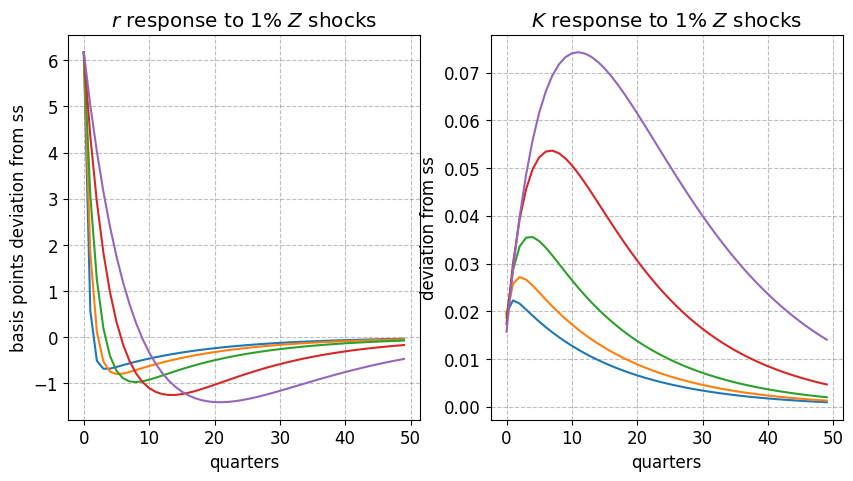

In [118]:
# === Let's Plot an IRF
rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9]) # For different rhos
dZ = 0.01 * ss['Z'] * rhos ** (np.arange(T)[:, np.newaxis]) # get T*5 matrix of dZ
dr = G['r']['Z'] @ dZ
dk = G['K']['Z'] @ dZ

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 5)) # Ax1 is consumption ax2 is savings
ax1.plot(10000*dr[:50, :])
ax1.set_title(r'$r$ response to 1% $Z$ shocks')
ax1.set_ylabel(r'basis points deviation from ss')
ax1.set_xlabel(r'quarters')
#plt.savefig(path + "/policy_func.png", bbox_inches='tight')

ax2.plot(dk[:50, :])
ax2.set_title(r'$K$ response to 1% $Z$ shocks')
ax2.set_ylabel(r'deviation from ss')
ax2.set_xlabel(r'quarters')


plt.savefig(path + "/TFP_shock.png", bbox_inches='tight')
plt.show()





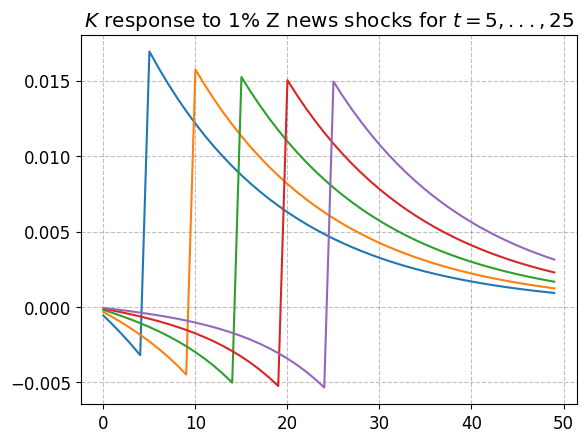

In [119]:
# We can also plot individual "future" shocks such as news shocks.
# Each element of G gives the response of a future increase in Z.

dZ = 0.01*(np.arange(T)[:, np.newaxis] == np.array([5, 10, 15, 20, 25]))
dK = G['K']['Z'] @ dZ

plt.plot(dK[:50])
plt.title('$K$ response to 1% Z news shocks for $t=5,...,25$')
plt.show()

#### Building the matrices H from scratch
We can also combine the Jacobians to form the GE effect from scratch. 

Recall that the KS model, the excess demand function is:

$$
H_t(K, Z) \equiv \mathcal{K}_t\left(\left\{\alpha Z_s K_{s-1}^{\alpha-1} - \delta, (1-\alpha) Z_s K_{s-1}^{\alpha}\right\}\right) - K_t = 0.
$$

This is the composition of the household capital supply function $\mathcal{K}$ with the interest rate $r(K_{t-1}, Z_t) = \alpha Z_t K_{t-1}^{\alpha-1} - \delta$ and wage $w(K_{t-1}, Z_t) = (1-\alpha) Z_t K_{t-1}^{\alpha}$ functions.

First, we must compute the firm and HH jacobians, then combine them manually applying the chain rule. Finally, we construct the  $H(K,Z)$ and then use the implicit theorem to get the GE effect of $Z$ on $K$.

This part I took from the SSJ notebook (Krussell-Smith), look there for more details.

In [120]:

# firm Jacobian: r and w as functions of K and Z
J_firm = firm.jacobian(ss, inputs=['K', 'Z'])
# household Jacobian: curlyK (called 'a' for assets by J_ha) as function of r and w
T = 500
J_ha = household.jacobian(ss, inputs=['r', 'w'], T=T)

# Effect on J_K using the chain rule
J_curlyK_K = J_ha['A']['r'] @ J_firm['r']['K'] + J_ha['A']['w'] @ J_firm['w']['K']
J_curlyK_Z = J_ha['A']['r'] @ J_firm['r']['Z'] + J_ha['A']['w'] @ J_firm['w']['Z']

J = copy.deepcopy(J_firm)
J.update(JacobianDict({'curlyK': {'K' : J_curlyK_K, 'Z' : J_curlyK_Z}}))

H_K = J['curlyK']['K'] - np.eye(T)
H_Z = J['curlyK']['Z']

G_manual = {'K': -np.linalg.solve(H_K, H_Z)}

print("Response of Capital to a TFP Shock (manually calculated):\n ", G_manual['K'])

print("\nResponse of Capital to a TFP Shock (using the package):\n ", G['K']['Z'])


Response of Capital to a TFP Shock (manually calculated):
  [[ 1.98635648e+00 -9.05286986e-02 -8.02737719e-02 ... -5.98168686e-11
  -5.82247773e-11 -5.64397988e-11]
 [ 1.85512719e+00  1.90420214e+00 -1.64488307e-01 ... -1.16300180e-10
  -1.13103037e-10 -1.09717653e-10]
 [ 1.73339133e+00  1.77955913e+00  1.83615655e+00 ... -1.69530552e-10
  -1.64940318e-10 -1.59941364e-10]
 ...
 [-5.48845725e-08 -5.16839437e-08 -4.88240379e-08 ...  1.97993102e+00
  -1.45152786e-02  7.63050611e-02]
 [-5.57069921e-08 -5.24588511e-08 -4.95565420e-08 ...  1.93873351e+00
   2.07008810e+00  8.17501951e-02]
 [-5.67820202e-08 -5.34716150e-08 -5.05137192e-08 ...  1.90969003e+00
   2.03887292e+00  2.17701223e+00]]

Response of Capital to a TFP Shock (using the package):
  [[ 1.98635648e+00 -9.05286986e-02 -8.02737719e-02 ... -5.98168686e-11
  -5.82247773e-11 -5.64397988e-11]
 [ 1.85512719e+00  1.90420214e+00 -1.64488307e-01 ... -1.16300180e-10
  -1.13103037e-10 -1.09717653e-10]
 [ 1.73339133e+00  1.77955913e+00  

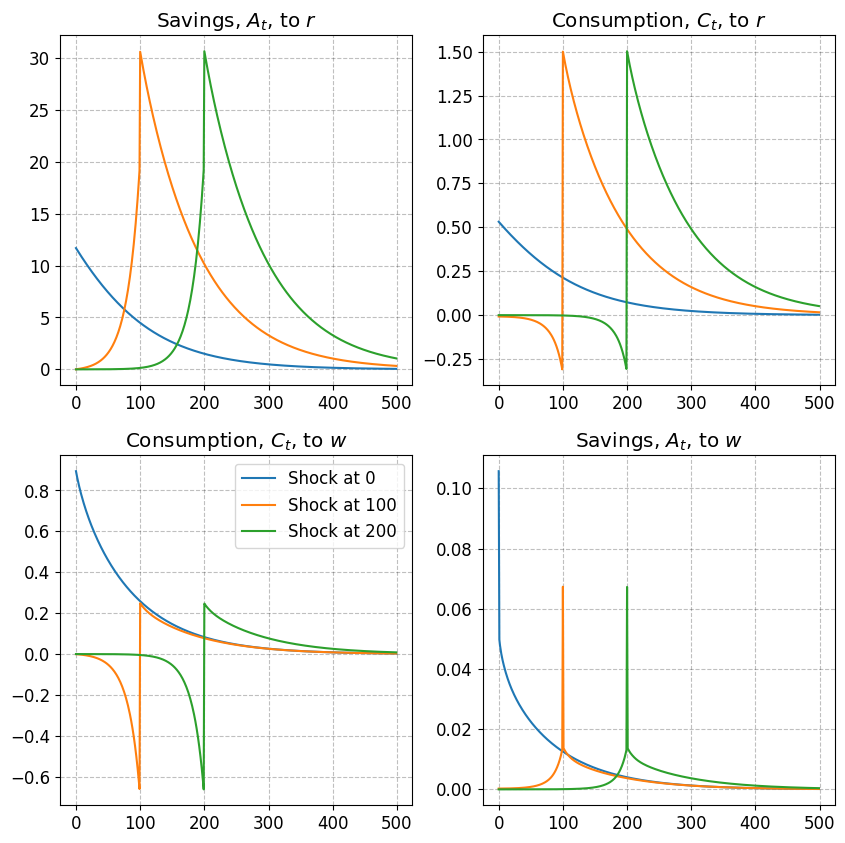

In [133]:
# Sometime it is useful to  look at the Jacobians themselve. For instance:\
    
fig, axs = plt.subplots(2,2,figsize=(10, 10)) # Ax1 is consumption ax2 is savings
for s in [0,100,200]:
    axs[0,0].plot(np.arange(T),J_ha['A']['r'][:,s])
    axs[0,1].plot(np.arange(T),J_ha['C']['r'][:,s])
    axs[1,1].plot(np.arange(T),J_ha['C']['w'][:,s])       
    axs[1,0].plot(np.arange(T),J_ha['A']['w'][:,s],label=f'Shock at {s}')

axs[1,0].legend(frameon=True)

axs[0,0].set_title(f'Savings, $A_t$, to $r$')
axs[0,1].set_title(f'Consumption, $C_t$, to $r$')
axs[1,1].set_title(f'Savings, $A_t$, to $w$')       
axs[1,0].set_title(f'Consumption, $C_t$, to $w$')

plt.savefig(path + "/jacobians.png", bbox_inches='tight')

## Nonlinear perfect foresight dynamics (taken from SSJ notebooks)

Linearized impulse responses are invariant to the sign and size of aggregate shocks by construction. Although this is not a problem for many applications, it is clearly a limitation. Here, we demonstrate that the Jacobian is also extremely useful in solving for nonlinear dynamics.

Consider the case of an economy that starts at the steady state, and receives an unexpected shock at date 0. This is often called an "MIT shock". 

For a given shock $Z$, the solution is still characterized by the $K$ that solves $H(K,Z)=0$. Our algorithm to find this $K$, a simple variant of Newton's method, iterates on a sequence of guesses $K^j$ for the path of capital as follows:
1. starting with $j=0$, guess a path $K^0$
2. calculate $H(K^j, Z)$
3. update the guess according to $$K^{j+1} = K^j - H_K(K_{ss}, Z_{ss})^{-1} H(K^j, Z)$$
and return to step 2 for $j+1$

The only difference between this and the standard Newton's method is that we use the Jacobian $H_K$ around the steady state (which we have already calculated), rather than the Jacobian around the current guess (which is somewhat more difficult to calculate). Still, this tends to achieve extremely fast convergence.

Although iterative methods to solve for equilibrium in response to MIT shocks are quite common in the heterogeneous-agent literature, these methods generally use ad-hoc rules for updating the guess, which can be fragile and slow. In applications with no or limited heterogeneity (such as spender-saver models) where it is possible to calculate Jacobians easily, Newton's method has been used to provide faster and more robust convergence -- see, for instance, [Juillard (1996)](http://www.cepremap.fr/depot/couv_orange/co9602.pdf).

But until now, this has not been applied to heterogeneous-agent models, since the Jacobian has been too difficult to calculate. The only partial applications to date, to our knowledge, are in [Auclert and Rognlie (2018)](http://web.stanford.edu/~aauclert/computational_appendix_inequad.pdf), which uses an auxiliary model to compute an approximate Jacobian, and in [Straub (2018)](https://scholar.harvard.edu/files/straub/files/jmp_straub_jan_2.pdf), which uses interpolation to compute an approximate Jacobian. In this paper, however, we have provided a highly efficient method to compute the *exact* Jacobian around the steady state for any heterogeneous-agent model, and can thus readily apply Newton's method.

#### Implementation

Our quasi-Newton method can be implemented in two steps. First, build the nonlinear function $H(U, Z).$ Second, guess $U$ for a given $Z$ and iterate until convergence. We automatized both of these, so all we need to do is call the `solve_impulse_nonlinear` method for the `ks` object. We will also solve for the linearized dynamics using the `solve_impulse_linear` method for comparison. 

Note that both the shock and the results (in an `ImpulseDict` object) are expressed in deviations from ss.

Solving Krusell-Smith for ['K'] to hit ['asset_mkt']
On iteration 0
   max error for asset_mkt is 8.92E-02
On iteration 1
   max error for asset_mkt is 1.27E-04
On iteration 2
   max error for asset_mkt is 2.01E-07
On iteration 3
   max error for asset_mkt is 1.26E-10
<ImpulseDict: ['Z', 'K', 'A', 'C', 'r', 'w', 'Y', 'asset_mkt', 'goods_mkt'], internals=['hh']>


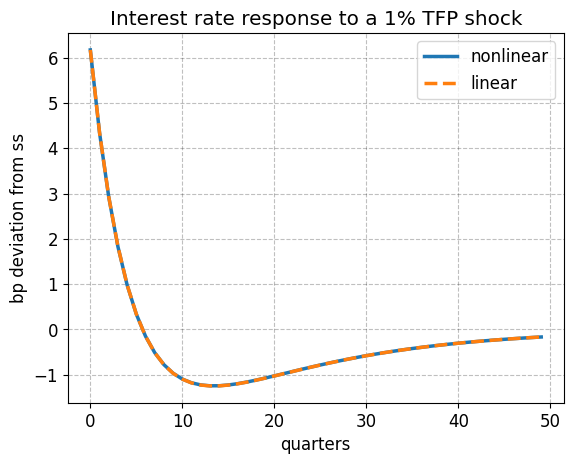

In [135]:
Z_shock_path = {"Z": 0.01*0.8**np.arange(T)}

td_nonlin = ks_model.solve_impulse_nonlinear(ss, unknowns, targets, Z_shock_path)
td_lin = ks_model.solve_impulse_linear(ss, unknowns, targets, Z_shock_path)

print(td_nonlin)

dr_nonlin = 10000 * td_nonlin['r']
dr_lin = 10000 * td_lin['r']

plt.plot(dr_nonlin[:50], label='nonlinear', linewidth=2.5)
plt.plot(dr_lin[:50], label='linear', linestyle='--', linewidth=2.5)
plt.title(r'Interest rate response to a 1% TFP shock')
plt.ylabel(r'bp deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

## Set up Heterogeneous-agent Block (taken from SSJ notebooks)

As mention before the SSJ package comes with 3 generic HetBlocks, located in `sequence_jacobian/hetblocks`.
- `hh_sim`: standard incomplete markets model
- `hh_labor`: standard incomplete markets model with frictionless labor supply
- `hh_twoasset`: two-asset model with convex portfolio adjustment cost

For some models, you might have to create your own HA block. SSJ illustrates the steps in the KS notebook:

"
Solving a HA problem consists of 3 distinct steps.
1. **backward iteration**: solve for individual policy functions
2. **forward iteration**: solve for distribution
3. **aggregation**: obtain macro outcomes
   
Backward iteration is model specific, and requires careful consideration. Forward iteration is fairly mechanical. It depends only on the number and type (discrete or continuous) state variables. Aggregation is completely mechanical. As such, we ask users only to provide a recipe for backward iteration. Forward iteration and aggregation is handled automatically. 

So, the main task is to write a **backward step function** that represents the Bellman equation. This has to be a single step of an iterative solution method such as value function iteration that solves for optimal policy on a grid. For the standard income fluctuation problem we're dealing with here, the endogenous gridpoint method (EGM) of [Carroll (2006)](https://www.sciencedirect.com/science/article/pii/S0165176505003368) is the best practice.
- Formally, we need to write a function that maps the expected value of a "backward variable" tomorrow into the "backward variable" today, on the same grid. In the EGM, the backward variable is the partial of the value function with respect to assets, thus the backward step function is $f: \mathbb{E}\left[\partial_k V(e', k)\right|e] \to \partial_k V(e, k_{-}).$

Once we have the backward step function, we can use the decorator `@het` to turn it into an instance of HetBlock. All we have to do is specify:
- `exogenous`: name of the transition matrix for discrete exogenous state(s) (one or more, in forward order)
- `policy`: name of policy corresponding to the continuous endogenous state(s) (one or two)
- `backward`: name of backward variable(s) on which we're iterating (here the first derivative `Va` of the value function with respect to assets)
- `backward_init`: a function that initializes a guess for the backward variable 

"

In [136]:
def household_init(a_grid, e_grid, r, w, eis): # Initial guess
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)
    return Va

@het(exogenous='Pi', policy='a', backward='Va', backward_init=household_init)
def household(Va_p, a_grid, e_grid, r, w, beta, eis):
    """Single backward iteration step using endogenous gridpoint method for households with CRRA utility.

    Parameters
    ----------
    Va_p     : array (nE, nA), expected marginal value of assets next period
    a_grid   : array (nA), asset grid
    e_grid   : array (nE), producticity grid
    r        : scalar, ex-post real interest rate
    w        : scalar, wage
    beta     : scalar, discount factor
    eis      : scalar, elasticity of intertemporal substitution

    Returns
    ----------
    Va : array (nE, nA), marginal value of assets today
    a  : array (nE, nA), asset policy today
    c  : array (nE, nA), consumption policy today
    """
    uc_nextgrid = beta * Va_p  # This uses the EGM with the value function.
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]
    a = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    misc.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis)
    return Va, a, c

Recall that every block (including HA blocks) represent a function in sequence space. HA blocks are special in that they have macro outputs (aggregates) but also micro outputs (distribution, policy functions).

In [137]:
print(household)
print(f'Inputs: {household.inputs}')
print(f'Macro outputs: {household.outputs}')
print(f'Micro outputs: {household.internals}')

<HetBlock 'household'>
Inputs: ['a_grid', 'e_grid', 'r', 'w', 'beta', 'eis', 'Pi']
Macro outputs: ['A', 'C']
Micro outputs: ['D', 'Dbeg', 'Pi', 'Va', 'a', 'c']


The inputs of the `household` block include scalars (`w`, `r`, `eis`, `beta`) and arrays (`a_grid`, `e_grid`, `Pi`). A key assumption of the SSJ method is that blocks are only connected via scalars (scalar sequences). This ensures that all blocks have compatible Jacobians that can be accumulated along the DAG. Multidimensional inputs should be thought of as **internal** to a specific HetBlock. 

This convention is facilitated by `hetinput` and `hetoutput` functions. These are regular Python functions that we can attach to a HetBlock. The purpose of hetinputs is to map scalars (from outside the block) into the multidimensional inputs that the block needs. The purpose of hetoutputs is to map multidimensional outputs of the block (e.g. `a`, `c`) into new multidimensional outputs of interest. Think of it as follows. A HetBlock is evaluated in 3 steps.
1. evaluate hetinputs; obtain multidimensional inputs
2. evaluate core block (backward iteration); obtain policy functions
3. evaluate hetoutputs; obtain other outputs of interest

A single HetBlock may have zero or multiple `hetinputs` and `hetoutputs`. Moreover, hetinputs are allowed to depend on each other in an acyclic fashion. Same for hetoutputs.  

Continuing with our example, let's attach a hetinput function that creates the grid. Notice that `household_ext` does not have multidimensional inputs anymore. It knows how to make them internally, by calling `make_grid`. 

In [5]:
def make_grid(rho_e, sd_e, nE, amin, amax, nA):
    e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
    a_grid = grids.agrid(amin=amin, amax=amax, n=nA)
    return e_grid, Pi, a_grid


household_ext = household.add_hetinputs([make_grid])

print(household_ext)
print(f'Inputs: {household_ext.inputs}')

<HetBlock 'household' with hetinput 'make_grid'>
Inputs: ['r', 'w', 'beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA']


Let's put the model together. Everything now works as before.

In [7]:
ks = create_model([household_ext, firm, mkt_clearing], name="Krusell-Smith")
print(ks.inputs)

['beta', 'eis', 'rho_e', 'sd_e', 'nE', 'amin', 'amax', 'nA', 'K', 'L', 'Z', 'alpha', 'delta']
